<a href="https://colab.research.google.com/github/emily-l-torres/talkofthetown/blob/main/notebooks/TOTT_PostGlove_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

import ast, re, string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from google.colab import files
import os, glob, time, gc, psutil
import pathlib
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/MyDrive/talkofthetown /content/talkofthetown

Mounted at /content/drive


***I included the same join workflow from the main TOTT notebook - I'm not sure it is truly needed for this notebook.***

In [ ]:
reviews_path = '/content/talkofthetown/data/yelp_academic_dataset_processed_reviews.csv'
reviews = pd.read_csv(reviews_path).drop(columns=['name'])
biz_path = '/content/talkofthetown/data/clean_data_business/business_clean.csv'
biz_df = pd.read_csv(biz_path, usecols=['business_id', 'name', 'city'], dtype=str)
enriched_reviews_df = reviews.merge(biz_df, how='left', on='business_id')
cols = [
    'business_id',
    'name',
    'city',
    'date',
    'stars',
    'text',
    'text_clean',
    'text_length',
    'word_count',
    'sentiment_binary',
    'sentiment_multiclass'
]

enriched_reviews_df = enriched_reviews_df[cols]
enriched_reviews_df.stars = enriched_reviews_df.stars.astype(int)
enriched_reviews_df.info()
enriched_reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   business_id           250000 non-null  object
 1   name                  250000 non-null  object
 2   city                  250000 non-null  object
 3   date                  250000 non-null  object
 4   stars                 250000 non-null  int64 
 5   text                  250000 non-null  object
 6   text_clean            249999 non-null  object
 7   text_length           250000 non-null  int64 
 8   word_count            250000 non-null  int64 
 9   sentiment_binary      250000 non-null  int64 
 10  sentiment_multiclass  250000 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.0+ MB


,business_id,name,city,date,stars,text,text_clean,text_length,word_count,sentiment_binary,sentiment_multiclass
0,04UD14gamNjLY0IDYVhHJg,Dmitri's,Philadelphia,2015-09-23 23:10:31,1,I am a long term frequent customer of this est...,i am a long term frequent customer of this est...,341,65,0,negative
1,-OIUunijjcq_ZzyyQhPPFQ,Zorba's Taverna,Philadelphia,2012-09-10 17:07:50,1,"I got the gyro ""platter"" for lunch, which was ...","i got the gyro ""platter"" for lunch, which was ...",279,48,0,negative
2,VbItL6RDULtnw4YvB6EhVg,Jon's Bar & Grille,Philadelphia,2008-04-30 14:54:01,1,They served me a frozen pizza and skunked beer...,they served me a frozen pizza and skunked beer...,60,11,0,negative
3,R-HCwu9UbasUudG1yTM1Ow,TD Banknorth,Philadelphia,2009-10-15 00:08:18,1,I am positively LIVID.\n\nI went to check my a...,i am positively livid. i went to check my acco...,998,193,0,negative
4,r2cjbHG_WGWUkaPCbLpo-A,Philly Fusion & Grill Chicken Bowl,Philadelphia,2015-08-06 22:35:02,1,This place's posted hours include a 10PM closi...,this place's posted hours include a 10pm closi...,396,74,0,negative


In [ ]:

# Raw counts of 0 vs 1 per city
city_counts = pd.crosstab(
    enriched_reviews_df['city'],
    enriched_reviews_df['sentiment_binary']
).rename(columns={0: 'neg', 1: 'pos'})

print(city_counts)

sentiment_binary    neg    pos
city                          
Boise             15000  10000
Indianapolis      15000  10000
Nashville         15000  10000
New Orleans       15000  10000
Philadelphia      15000  10000
Reno              15000  10000
Saint Louis       15000  10000
Santa Barbara     15000  10000
Tampa             15000  10000
Tucson            15000  10000


In [ ]:
city_pct = pd.crosstab(
    enriched_reviews_df['city'],
    enriched_reviews_df['sentiment_binary'],
    normalize='index'
).round(3).rename(columns={0: 'neg', 1: 'pos'})

print(city_pct)

sentiment_binary  neg  pos
city                      
Boise             0.6  0.4
Indianapolis      0.6  0.4
Nashville         0.6  0.4
New Orleans       0.6  0.4
Philadelphia      0.6  0.4
Reno              0.6  0.4
Saint Louis       0.6  0.4
Santa Barbara     0.6  0.4
Tampa             0.6  0.4
Tucson            0.6  0.4


***This would possibly explain our LR evalutation imbalance - however you'll see we set an "imbalanced = True" parameter on the LR model, so not sure how we can improve score balance***

In [ ]:
city_root = '/content/talkofthetown/talkofthetown/data/city_data'
city_paths = glob.glob(os.path.join(city_root, '*_reviews.csv'))

city_vars = []

for path in city_paths:

    city_name = os.path.basename(path).replace("_reviews.csv", "")
    var_name  = f"{city_name.replace(' ', '_')}_reviews"

    globals()[var_name] = pd.read_csv(path, converters={'text':ast.literal_eval})
    city_vars.append(var_name)

print('Created the following city dataframe objects:\n\n' + ',\n'.join(city_vars))

Created the following city dataframe objects:

New_Orleans_reviews,
Philadelphia_reviews,
Nashville_reviews,
Tucson_reviews,
Tampa_reviews,
Indianapolis_reviews,
Santa_Barbara_reviews,
Reno_reviews,
Boise_reviews,
Saint_Louis_reviews


***Just realized, we can probably simply read these CSVs and put to objects instead, as these CSVs were already created in the main TOTT notebook.***

In [ ]:
root = pathlib.Path("/content/talkofthetown/data/glove_embeddings")
root.mkdir(parents=True, exist_ok=True)

embedding_master = np.load(root / 'master_embeddings.npz', mmap_mode='r')

cities = [
    'Indianapolis','Boise','Philadelphia',
    'New_Orleans','Nashville','Tampa',
    'Santa_Barbara','Saint_Louis','Reno','Tucson'
]

embedding_map = {
    city: pd.DataFrame(
        embedding_master[f"{city}_embeds"],     # embedding matrix
        index=embedding_master[f"{city}_vocab"]  # vocab as row index
                      ) for city in cities}

reviews_map = {city: globals()[f'{city}_reviews']  for city in cities}

**Per-City Binary Sentiment Classification (Logistic Regression)**

In [ ]:
for city in cities:

    data   = np.load(root / f"{city}.npz", mmap_mode="r")
    matrix = data["embeds"]            # shape = (V, D)
    vocab  = data["vocab"].tolist()    # list of V tokens
    token2idx = {tok:i for i,tok in enumerate(vocab)}

    df      = reviews_map[city]
    token_lists = df["text"]           # list-of-token lists
    stars       = df["stars"].values

    D = matrix.shape[1]
    X, y = [], []

    for toks, star in zip(token_lists, stars):
        vecs = [matrix[token2idx[t]] for t in toks if t in token2idx]
        doc = np.mean(vecs, axis=0) if vecs else np.zeros(D)
        X.append(doc)
        y.append(1 if star >= 4 else 0)

    X = np.vstack(X).astype("float32")
    y = np.array(y, dtype="int8")

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
    )
    clf = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced').fit(Xtr, ytr)

    yhat_tr = clf.predict(Xtr)
    print(f"\n=== {city} Training Set Report ===")
    print(classification_report(ytr, yhat_tr,
                            target_names=['negative', 'positive']))
    yhat_te = clf.predict(Xte)
    print(f"\n=== {city} Testing Set Report ===")
    print(classification_report(yte, yhat_te,
                            target_names=['negative', 'positive']))


=== Indianapolis Training Set Report ===
              precision    recall  f1-score   support

    negative       0.85      0.81      0.83     12000
    positive       0.74      0.79      0.76      8000

    accuracy                           0.80     20000
   macro avg       0.79      0.80      0.80     20000
weighted avg       0.81      0.80      0.80     20000


=== Indianapolis Testing Set Report ===
              precision    recall  f1-score   support

    negative       0.85      0.82      0.83      3000
    positive       0.74      0.79      0.76      2000

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.81      0.80      0.80      5000


=== Boise Training Set Report ===
              precision    recall  f1-score   support

    negative       0.83      0.80      0.82     12000
    positive       0.72      0.76      0.74      8000

    accuracy                           0.79     20000
   macro a

**Cumulative Per-City Confusion Matrix**

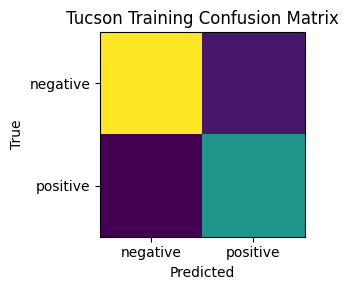

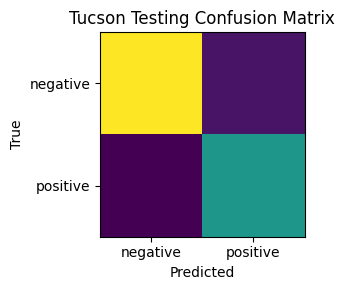

In [ ]:
cm_tr = confusion_matrix(ytr, yhat_tr, labels=[0, 1])
plt.figure(figsize=(4, 3))
plt.imshow(cm_tr, interpolation="nearest")
plt.xticks([0, 1], ["negative", "positive"])
plt.yticks([0, 1], ["negative", "positive"])
plt.title(f"{city} Training Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

cm_te = confusion_matrix(yte, yhat_te, labels=[0, 1])
plt.figure(figsize=(4, 3))
plt.imshow(cm_te, interpolation="nearest")
plt.xticks([0, 1], ["negative", "positive"])
plt.yticks([0, 1], ["negative", "positive"])
plt.title(f"{city} Testing Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


**Individual Per-City Confusion Matrices**

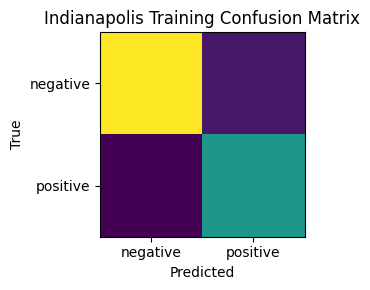

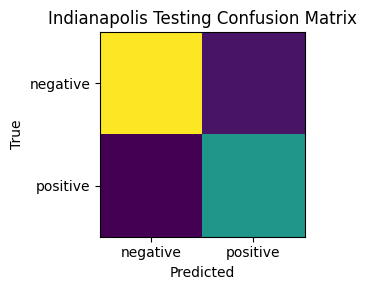

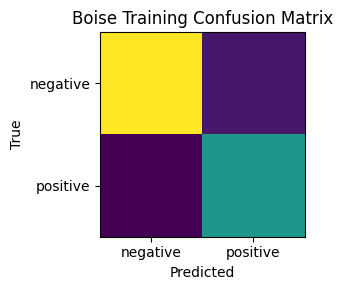

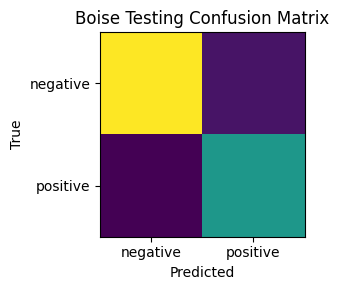

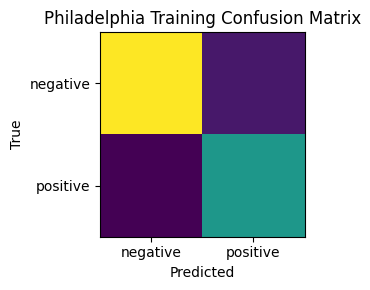

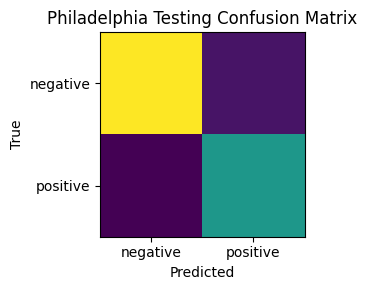

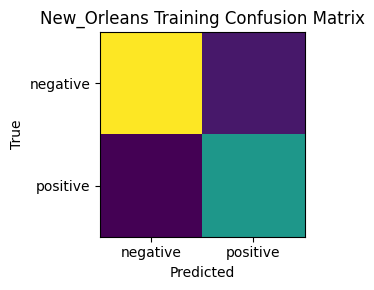

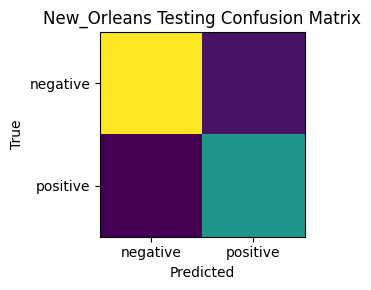

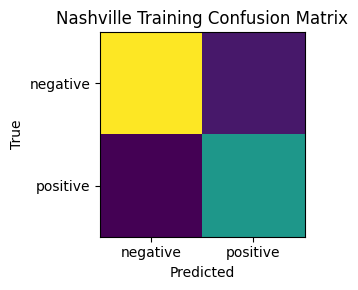

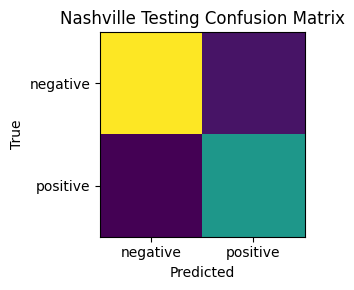

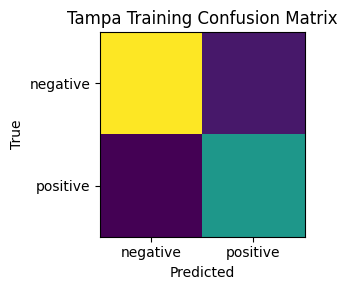

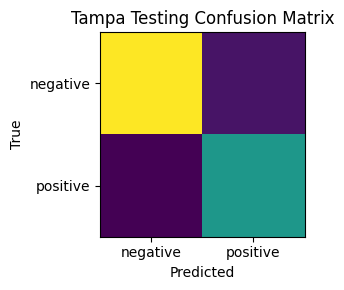

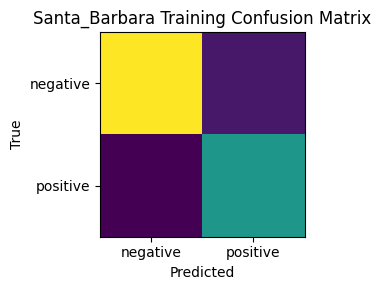

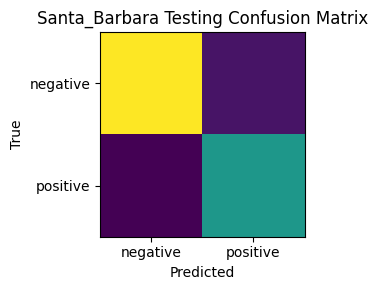

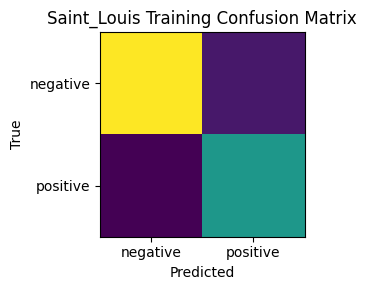

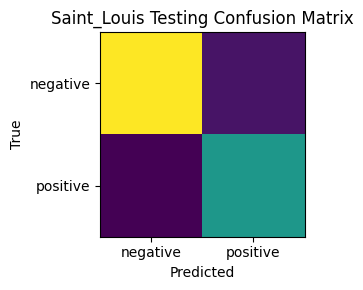

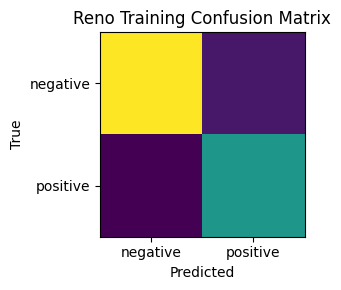

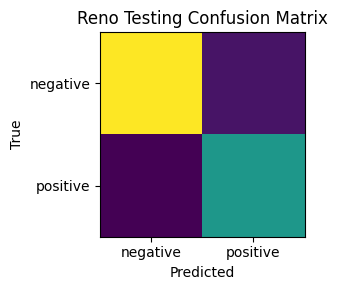

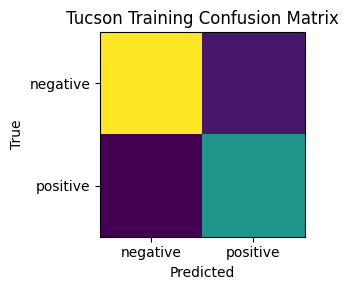

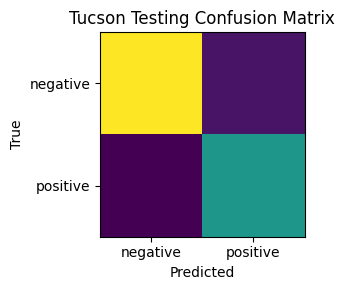

In [ ]:
for city in cities:

    cm_tr = confusion_matrix(ytr, yhat_tr, labels=[0, 1])
    plt.figure(figsize=(4, 3))
    plt.imshow(cm_tr, interpolation="nearest")
    plt.xticks([0, 1], ["negative", "positive"])
    plt.yticks([0, 1], ["negative", "positive"])
    plt.title(f"{city} Training Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

    cm_te = confusion_matrix(yte, yhat_te, labels=[0, 1])
    plt.figure(figsize=(4, 3))
    plt.imshow(cm_te, interpolation="nearest")
    plt.xticks([0, 1], ["negative", "positive"])
    plt.yticks([0, 1], ["negative", "positive"])
    plt.title(f"{city} Testing Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()